# **CS 181 HW4 Problem 2**

Only code you have to write are places marked with a TODO comment.

#### Loading datasets for K-Means and HAC:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from seaborn import heatmap
from scipy.spatial import distance

small_dataset = np.load("data/small_dataset.npy")
small_labels = np.load("data/small_dataset_labels.npy").astype(int)
large_dataset = np.load("data/large_dataset.npy")

## K-Means

In [2]:
class KMeans(object):
    # Initialize values for KMeans
    def __init__(self, K):
        self.K = K
        self.mean_images = None
        self.objective_values = []
        self.cluster_sizes = None

    # X is a (N x 28 x 28) array where 28x28 is the dimensions of each of the N images.
    def fit(self, X, max_iter=100, tol=1e-4):
        N, _ = X.shape
        
        # Start with random centroids (guesses)
        self.centroids = X[np.random.choice(N, self.K, replace=False)]
        
        
        for _ in range(max_iter):
            # Assign each data point to the nearest centroid
            distances = np.sqrt(((X - self.centroids[:, np.newaxis])**2).sum(axis=2))
            labels = np.argmin(distances, axis=0)
            
            # Updtae our centroids
            new_centroids = np.array([X[labels == k].mean(axis=0) for k in range(self.K)])
            
            # Check our updated guess fits the tolerance then break
            if np.abs(self.centroids - new_centroids).max() < tol:
                break
                
            self.centroids = new_centroids
        
            # Calculate and store the objective function 
            objective = ((X - self.centroids[labels])**2).sum()
            self.objective_values.append(objective)
            
        # Calculate mean of images
        self.mean_images = self.centroids
        
        # Find cluster sizes
        self.cluster_sizes = {}
        unique, counts = np.unique(labels, return_counts=True)
        for k, count in zip(unique, counts):
            self.cluster_sizes[k] = count

    # This should return the arrays for K images. Each image should represent the mean of each of the fitted clusters.
    def get_mean_images(self):
        return self.mean_images
    
    # Plot the objective function values across iterations
    def plot_verify_objective(self):
        plt.plot(self.objective_values)
        plt.xlabel('Iterations')
        plt.ylabel('Objective Function Value')
        plt.title('K-means Objective Function Convergence')
        plt.show()
    
    # This function returns the sizes of each cluster
    def get_cluster_sizes(self):
        return self.cluster_sizes


### Part 1: This takes seconds to run

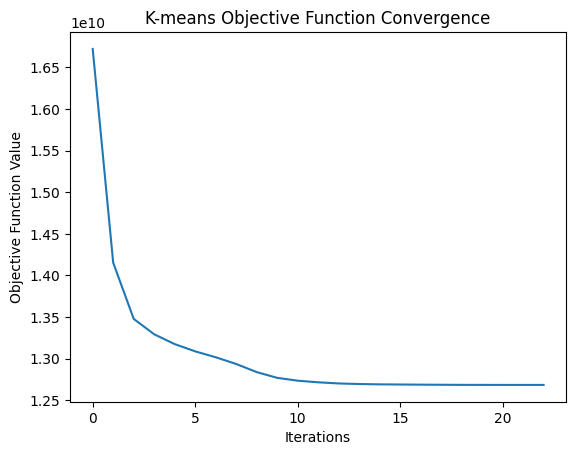

In [3]:
KMeansClassifier = KMeans(K=10)
KMeansClassifier.fit(large_dataset)
KMeansClassifier.plot_verify_objective()

Plotting code for parts 2 and 3

In [4]:
def make_mean_image_plot(data, standardized = False):
    niters = 3
    K = 10
    allmeans = np.zeros((K, niters, 784))
    for i in range(niters):
        KMeansClassifier = KMeans(K=K)
        KMeansClassifier.fit(data)
        allmeans[:,i] = KMeansClassifier.get_mean_images()
    fig = plt.figure(figsize=(10,10))
    plt.suptitle('Class mean images across random restarts' + (' (standardized data)' if standardized else ''), fontsize=16)
    for k in range(K):
        for i in range(niters):
            ax = fig.add_subplot(K, niters, 1+niters*k+i)
            plt.setp(ax.get_xticklabels(), visible=False)
            plt.setp(ax.get_yticklabels(), visible=False)
            ax.tick_params(axis='both', which='both', length=0)
            if k == 0: plt.title('Iter '+str(i))
            if i == 0: ax.set_ylabel('Class '+str(k), rotation=90)
            plt.imshow(allmeans[k,i].reshape(28,28), cmap='Greys_r')
    plt.show()

### Part 2: This takes ~3 minutes to run

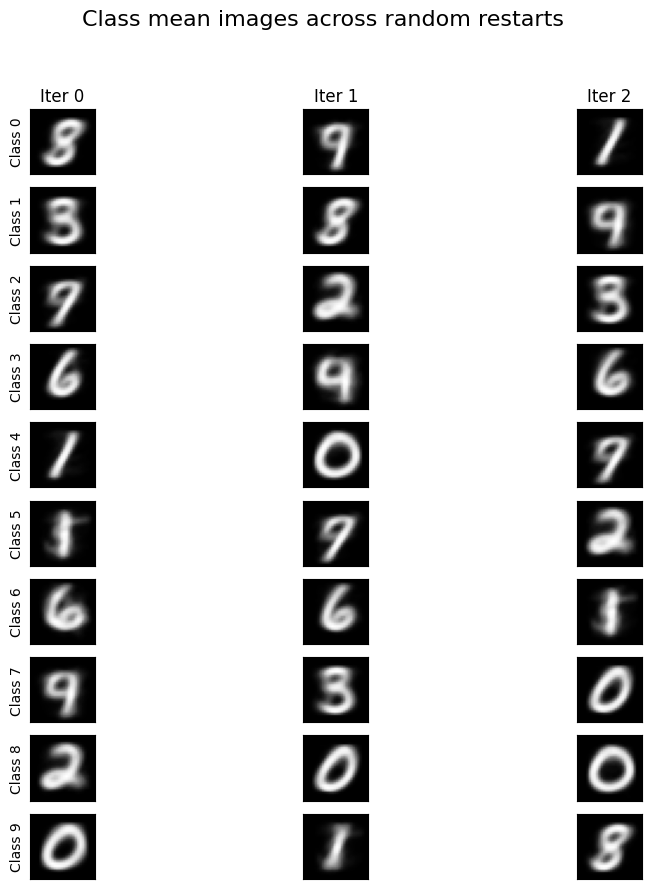

In [5]:
make_mean_image_plot(large_dataset)

### Part 3: This takes ~3 minutes to run

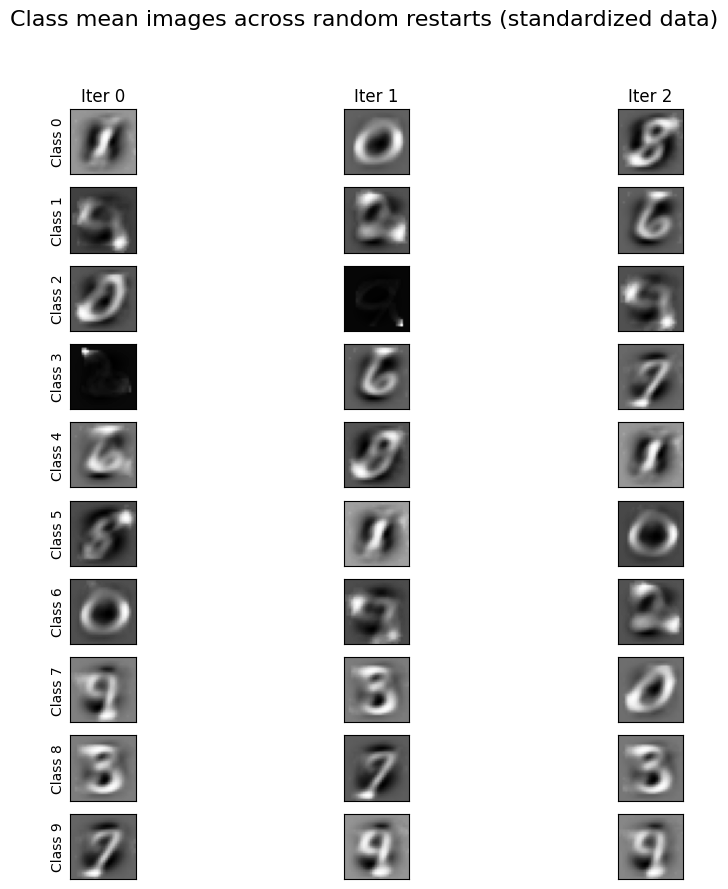

In [6]:
def standardize_data(X):
    # Find means and standard deviations
    means = np.mean(X, axis=0)
    stds = np.std(X, axis=0)
    
    # Avoid division by zero for pixels with zero variance
    stds[stds == 0] = 1
    
    # Standardize data
    X_std = (X - means) / stds
    
    return X_std

large_dataset_std = standardize_data(large_dataset) # TODO
make_mean_image_plot(large_dataset_std, standardized = True)

## HAC: Part 4

In [7]:
class HAC(object):
    def __init__(self, linkage):
        self.linkage = linkage
    
    def fit(self, X):
        self.X = X
        N, _ = X.shape
        # Each point starts as its own cluster
        self.labels = np.arange(N)  
        self.distances = distance.cdist(X, X)
        
    # Returns the mean image when using n_clusters clusters
    def get_mean_images(self, n_clusters):
        unique_labels = np.unique(self.labels)
        centroids = []
        for label in unique_labels:
            cluster_points = self.X[self.labels == label]
            centroids.append(cluster_points.mean(axis=0))
        return np.array(centroids[:n_clusters])
    
    # Return assignments when there were K clusters
    def get_k_clusters(self, K):
        cluster_labels = np.unique(self.labels)
        if len(cluster_labels) <= K:
            return self.labels
        else:
            # Merge clusters until reaching K clusters
            while len(cluster_labels) > K:
                min_distance = np.inf
                merge_indices = None
                for i, label1 in enumerate(cluster_labels):
                    for j, label2 in enumerate(cluster_labels):
                        if i < j:
                            distance_ij = self.calculate_linkage(label1, label2)
                            if distance_ij < min_distance:
                                min_distance = distance_ij
                                merge_indices = (i, j)
                if merge_indices is not None:
                    label1, label2 = cluster_labels[merge_indices[0]], cluster_labels[merge_indices[1]]
                    self.labels[self.labels == label2] = label1
                    cluster_labels = np.unique(self.labels)
            return self.labels
    
    # Calculate linkage between two clusters based on the selected linkage criteria
    def calculate_linkage(self, label1, label2):
        if self.linkage == 'min':
            return np.min(self.distances[self.labels == label1][:, self.labels == label2])
        elif self.linkage == 'max':
            return np.max(self.distances[self.labels == label1][:, self.labels == label2])
        elif self.linkage == 'centroid':
            centroid1 = self.X[self.labels == label1].mean(axis=0)
            centroid2 = self.X[self.labels == label2].mean(axis=0)
            return np.linalg.norm(centroid1 - centroid2)
    
    # Get cluster sizes to compare min and max linkage
    def get_cluster_sizes(self, K):
        unique_labels, counts = np.unique(self.get_k_clusters(K), return_counts=True)
        return dict(zip(unique_labels, counts))



### Part 4: This takes ~6 minutes to run

Done: max
Done: min
Done: centroid


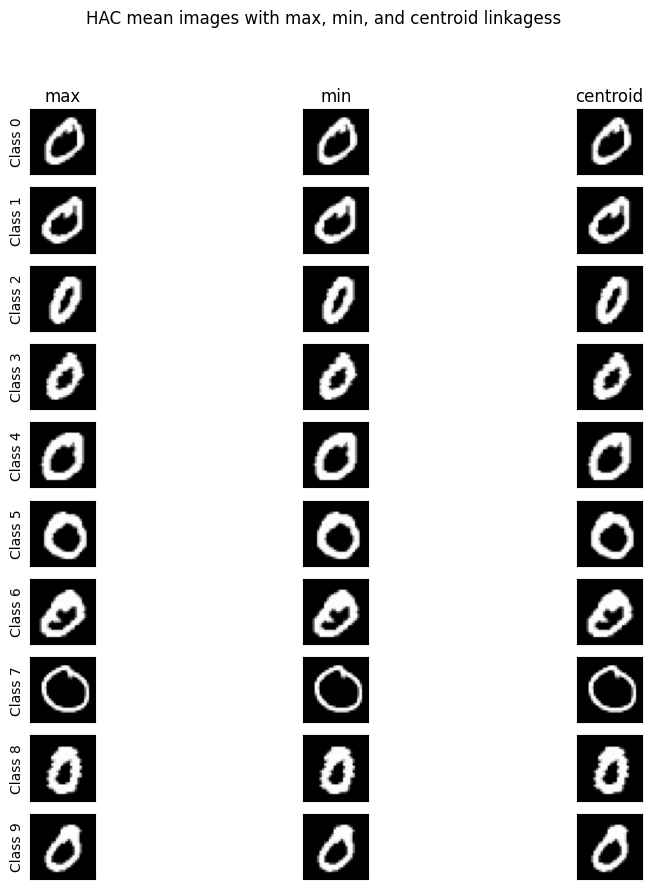

In [8]:
LINKAGES = [ 'max', 'min', 'centroid' ]
n_clusters = 10
cluster_sizes = []

fig = plt.figure(figsize=(10,10))
plt.suptitle("HAC mean images with max, min, and centroid linkagess")
for l_idx, l in enumerate(LINKAGES):
    # Fit HAC
    hac = HAC(l)
    hac.fit(small_dataset)
    mean_images = hac.get_mean_images(n_clusters)
    cluster_sizes.append(hac.get_cluster_sizes(n_clusters)) # used in Part 8, append here to avoid re-fitting
    # Make plot
    for m_idx in range(mean_images.shape[0]):
        m = mean_images[m_idx]
        ax = fig.add_subplot(n_clusters, len(LINKAGES), l_idx + m_idx*len(LINKAGES) + 1)
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)
        ax.tick_params(axis='both', which='both', length=0)
        if m_idx == 0: plt.title(l)
        if l_idx == 0: ax.set_ylabel('Class '+str(m_idx), rotation=90)
        plt.imshow(m.reshape(28,28), cmap='Greys_r')
    print("Done:", l)
plt.show()

### Part 5

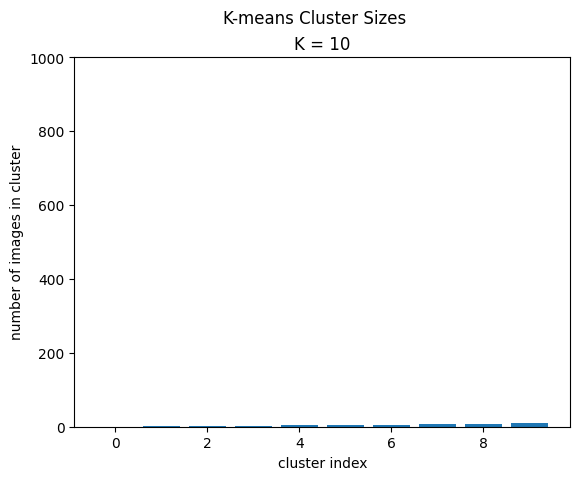

In [14]:
# Part 5: Create the graph for comparing cluster sizes in K-means
def plot_cluster_sizes(n_clusters, cluster_sizes):
    fig, (ax) = plt.subplots(1, 1)
    fig.suptitle("K-means Cluster Sizes")
    ax.set_ylabel('number of images in cluster')
    cluster_idxs = [i for i in range(n_clusters)]

    def plot_sizes_per_linkage(ax, sizes, k):
        ax.bar(cluster_idxs, sizes)
        ax.set_title(f'K = {k}')
        ax.set_xlabel('cluster index')
        ax.set_ylim(0, 1000)

    plot_sizes_per_linkage(ax, cluster_sizes, str(n_clusters))
    plt.show()

plot_cluster_sizes(KMeansClassifier.K, KMeansClassifier.get_cluster_sizes())

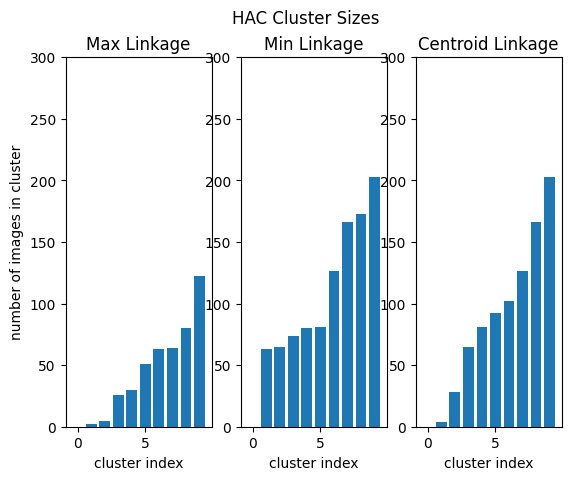

In [10]:
# Part 5: Create the graph for comparing cluster sizes in HAC
def plot_cluster_sizes(n_clusters, cluster_sizes):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.suptitle("HAC Cluster Sizes")
    ax1.set_ylabel('number of images in cluster')
    cluster_idxs = [i for i in range(n_clusters)]

    def plot_sizes_per_linkage(ax, sizes, linkage):
        ax.bar(cluster_idxs, sizes)
        ax.set_title(f'{linkage} Linkage')
        ax.set_xlabel('cluster index')
        ax.set_ylim(0, 300)

    plot_sizes_per_linkage(ax1, cluster_sizes[0], 'Max')
    plot_sizes_per_linkage(ax2, cluster_sizes[1], 'Min')
    plot_sizes_per_linkage(ax3, cluster_sizes[2], 'Centroid')
    plt.show()
plot_cluster_sizes(n_clusters, cluster_sizes)

### Part 6: Confusion Matrix

In [11]:
# TODO: implement code to produce confusion matrics
